
This notebook performs hyperparameter tuning for our best performing models (Random Forest and Gradient Boosting) from the baseline evaluation. We'll use `GridSearchCV` and create an ensemble of the tuned models.

## Objectives
1. Tune Random Forest and Gradient Boosting hyperparameters
2. Compare tuned vs untuned model performance
3. Create and evaluate a voting ensemble
4. Document findings and trade-offs

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV,  # Using RandomizedSearchCV instead of GridSearchCV
    cross_val_score
)
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    VotingRegressor
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from scipy.stats import randint, uniform  # For random parameter sampling

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualizations
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]

Load and preprocess the data using the same features and splits as our baseline models.

In [2]:
# Load the engineered features dataset
data = pd.read_csv('../../data/processed/engineered_features.csv')

# Select our identified important features
selected_features = [
    'risk_score_rolling_std',  # Primary predictors
    'dist_from_center',
    'time_window',
    'y',
    'hour',
    'offender_target_ratio',   # Secondary predictors
    'grid_id',
    'num_nearby',
    'dist_to_high_risk',       # Supporting predictors
    'day_of_week',
    'event_rate'
]

# Prepare features and target
X = data[selected_features]
y = data['risk_score']

# Handle infinite values and outliers (same as baseline)
inf_columns = X.columns[np.isinf(X).any()].tolist()
if inf_columns:
    print("\nColumns with infinite values:", inf_columns)
    for col in inf_columns:
        max_val = X[col][~np.isinf(X[col])].max()
        X[col] = X[col].replace([np.inf, -np.inf], max_val)

for col in X.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 3 * IQR
    lower_bound = Q1 - 3 * IQR
    X[col] = X[col].clip(lower_bound, upper_bound)

# Take a smaller subset for initial tuning (30% of data)
X_subset, _, y_subset, _ = train_test_split(X, y, train_size=0.3, random_state=42)

# Split the subset into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42
)

# Create preprocessor
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features)
    ]
)

print("Dataset shapes:")
print(f"Original data size: {X.shape}")
print(f"Subset size: {X_subset.shape}")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Columns with infinite values: ['event_rate']


C:\Users\Benja\AppData\Local\Temp\ipykernel_24740\4176336800.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].replace([np.inf, -np.inf], max_val)
C:\Users\Benja\AppData\Local\Temp\ipykernel_24740\4176336800.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].clip(lower_bound, upper_bound)
C:\Users\Benja\AppData\Local\Temp\ipykernel_24740\4176336800.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Dataset shapes:
Original data size: (400000, 11)
Subset size: (120000, 11)
Training set: (96000, 11)
Test set: (24000, 11)


Define parameter grids for both models and create evaluation functions.

In [3]:
# Parameter distributions for RandomizedSearchCV
rf_param_dist = {
    'regressor__n_estimators': randint(50, 200),  # Reduced range
    'regressor__max_depth': [None, 10, 20],  # Fewer options
    'regressor__min_samples_split': randint(2, 8),
    'regressor__min_samples_leaf': randint(1, 4),
    'regressor__max_features': ['sqrt', 'log2']
}

gb_param_dist = {
    'regressor__n_estimators': randint(50, 200),  # Reduced range
    'regressor__learning_rate': uniform(0.01, 0.09),  # Continuous distribution
    'regressor__max_depth': randint(3, 7),
    'regressor__subsample': uniform(0.8, 0.2),  # Continuous distribution
    'regressor__max_features': ['sqrt', 'log2']
}

def create_pipeline(model):
    """Create a pipeline with preprocessing and model."""
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model performance on train and test sets."""
    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
        'train_mae': mean_absolute_error(y_train, train_pred),
        'test_mae': mean_absolute_error(y_test, test_pred),
        'train_r2': r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred)
    }
    
    return metrics, train_pred, test_pred

def plot_residuals(y_true, y_pred, title):
    """Plot residuals to check for bias and heteroscedasticity."""
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {title}')
    plt.show()

Perform grid search for Random Forest hyperparameters.

In [4]:
# Create and tune Random Forest
rf_base = RandomForestRegressor(random_state=42)
rf_pipeline = create_pipeline(rf_base)

# Use RandomizedSearchCV with fewer iterations
rf_random = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=20,  # Reduced number of iterations
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='r2',
    random_state=42
)

print("Training Random Forest Random Search...")
rf_random.fit(X_train, y_train)

# Get best model and parameters
print("\nBest Random Forest Parameters:")
print(rf_random.best_params_)
print("\nBest Cross-validation Score:", rf_random.best_score_)

# Evaluate best model
rf_metrics, rf_train_pred, rf_test_pred = evaluate_model(
    rf_random.best_estimator_, X_train, X_test, y_train, y_test
)

print("\nBest Random Forest Performance:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.4f}")

Training Random Forest Random Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Random Forest Parameters:
{'regressor__max_depth': None, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 3, 'regressor__n_estimators': 160}

Best Cross-validation Score: 0.39520094159463615

Best Random Forest Parameters:
{'regressor__max_depth': None, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 3, 'regressor__n_estimators': 160}

Best Cross-validation Score: 0.39520094159463615

Best Random Forest Performance:
train_rmse: 0.0423
test_rmse: 0.0992
train_mae: 0.0290
test_mae: 0.0692
train_r2: 0.8944
test_r2: 0.4308

Best Random Forest Performance:
train_rmse: 0.0423
test_rmse: 0.0992
train_mae: 0.0290
test_mae: 0.0692
train_r2: 0.8944
test_r2: 0.4308


Perform grid search for Gradient Boosting hyperparameters.

In [5]:
# Create and tune Gradient Boosting
gb_base = GradientBoostingRegressor(random_state=42)
gb_pipeline = create_pipeline(gb_base)

# Use RandomizedSearchCV with fewer iterations
gb_random = RandomizedSearchCV(
    gb_pipeline,
    param_distributions=gb_param_dist,
    n_iter=20,  # Reduced number of iterations
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='r2',
    random_state=42
)

print("Training Gradient Boosting Random Search...")
gb_random.fit(X_train, y_train)

# Get best model and parameters
print("\nBest Gradient Boosting Parameters:")
print(gb_random.best_params_)
print("\nBest Cross-validation Score:", gb_random.best_score_)

# Evaluate best model
gb_metrics, gb_train_pred, gb_test_pred = evaluate_model(
    gb_random.best_estimator_, X_train, X_test, y_train, y_test
)

print("\nBest Gradient Boosting Performance:")
for metric, value in gb_metrics.items():
    print(f"{metric}: {value:.4f}")

Training Gradient Boosting Random Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Gradient Boosting Parameters:
{'regressor__learning_rate': np.float64(0.09183883618709038), 'regressor__max_depth': 6, 'regressor__max_features': 'log2', 'regressor__n_estimators': 153, 'regressor__subsample': np.float64(0.9510722820635306)}

Best Cross-validation Score: 0.25575024375671357

Best Gradient Boosting Parameters:
{'regressor__learning_rate': np.float64(0.09183883618709038), 'regressor__max_depth': 6, 'regressor__max_features': 'log2', 'regressor__n_estimators': 153, 'regressor__subsample': np.float64(0.9510722820635306)}

Best Cross-validation Score: 0.25575024375671357

Best Gradient Boosting Performance:
train_rmse: 0.1073
test_rmse: 0.1128
train_mae: 0.0769
test_mae: 0.0801
train_r2: 0.3210
test_r2: 0.2632

Best Gradient Boosting Performance:
train_rmse: 0.1073
test_rmse: 0.1128
train_mae: 0.0769
test_mae: 0.0801
train_r2: 0.3210
test_r2: 0.2632


Compare the performance of tuned models and create visualization of results.

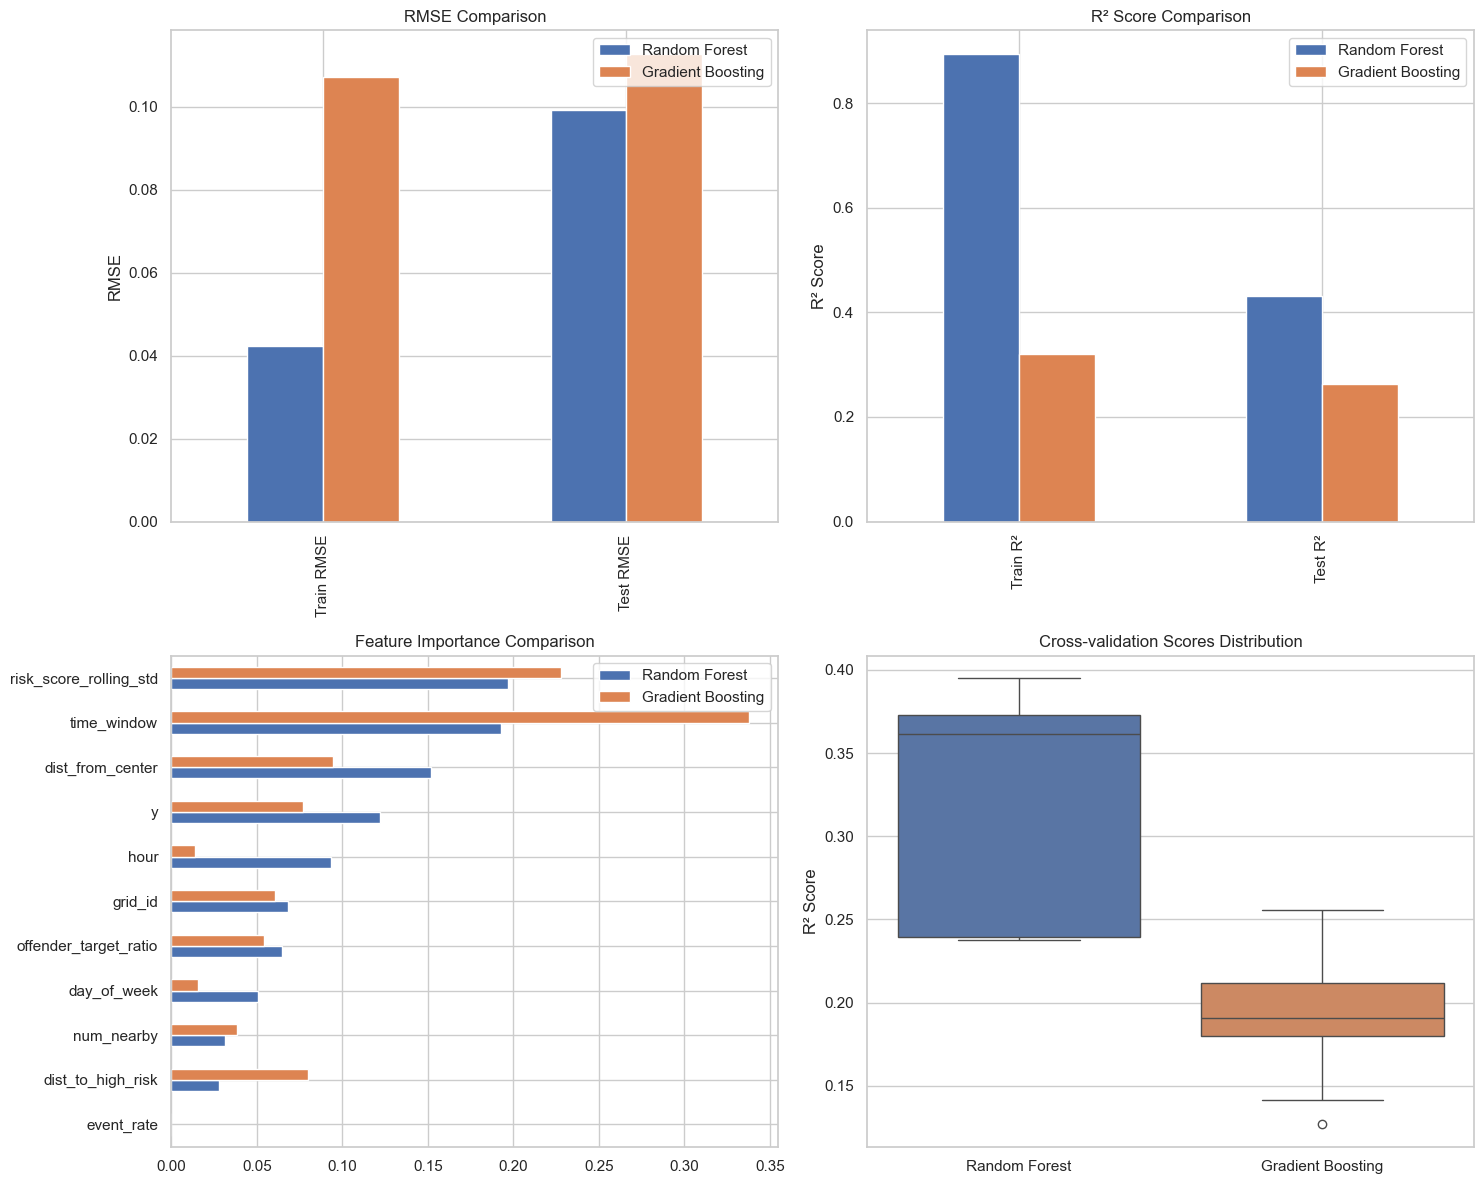

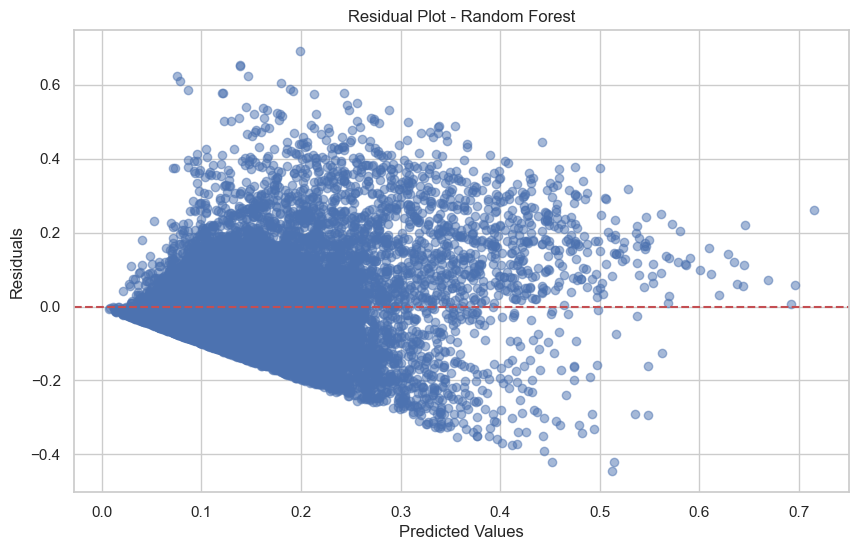

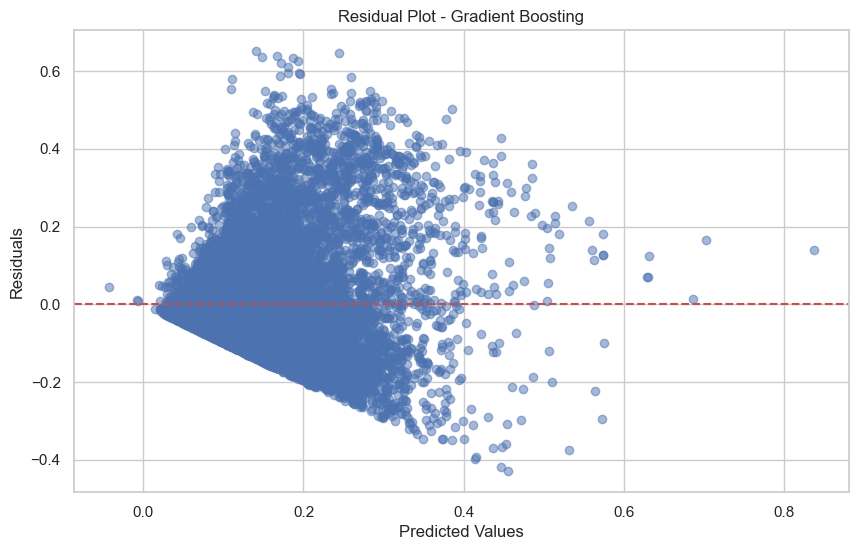

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. RMSE Comparison
models_comparison = pd.DataFrame({
    'Random Forest': [rf_metrics['train_rmse'], rf_metrics['test_rmse']],
    'Gradient Boosting': [gb_metrics['train_rmse'], gb_metrics['test_rmse']]
}, index=['Train RMSE', 'Test RMSE'])

models_comparison.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('RMSE Comparison')
axes[0,0].set_ylabel('RMSE')

# 2. R² Comparison
r2_comparison = pd.DataFrame({
    'Random Forest': [rf_metrics['train_r2'], rf_metrics['test_r2']],
    'Gradient Boosting': [gb_metrics['train_r2'], gb_metrics['test_r2']]
}, index=['Train R²', 'Test R²'])

r2_comparison.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('R² Score Comparison')
axes[0,1].set_ylabel('R² Score')

# 3. Feature Importance
rf_importance = pd.Series(
    rf_random.best_estimator_.named_steps['regressor'].feature_importances_,
    index=selected_features
)

gb_importance = pd.Series(
    gb_random.best_estimator_.named_steps['regressor'].feature_importances_,
    index=selected_features
)

feature_importance = pd.DataFrame({
    'Random Forest': rf_importance,
    'Gradient Boosting': gb_importance
})

feature_importance.sort_values('Random Forest', ascending=True).plot(
    kind='barh', ax=axes[1,0]
)
axes[1,0].set_title('Feature Importance Comparison')

# 4. Random Search Results
cv_results = pd.DataFrame({
    'Random Forest': pd.Series(rf_random.cv_results_['mean_test_score']),
    'Gradient Boosting': pd.Series(gb_random.cv_results_['mean_test_score'])
})

sns.boxplot(data=cv_results, ax=axes[1,1])
axes[1,1].set_title('Cross-validation Scores Distribution')
axes[1,1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()

# Plot residuals
plot_residuals(y_test, rf_test_pred, 'Random Forest')
plot_residuals(y_test, gb_test_pred, 'Gradient Boosting')

Create and evaluate a voting ensemble using the tuned models.

Training Voting Ensemble...

Voting Ensemble Performance:
train_rmse: 0.0737
test_rmse: 0.1044
train_mae: 0.0525
test_mae: 0.0740
train_r2: 0.6800
test_r2: 0.3685

Voting Ensemble Performance:
train_rmse: 0.0737
test_rmse: 0.1044
train_mae: 0.0525
test_mae: 0.0740
train_r2: 0.6800
test_r2: 0.3685


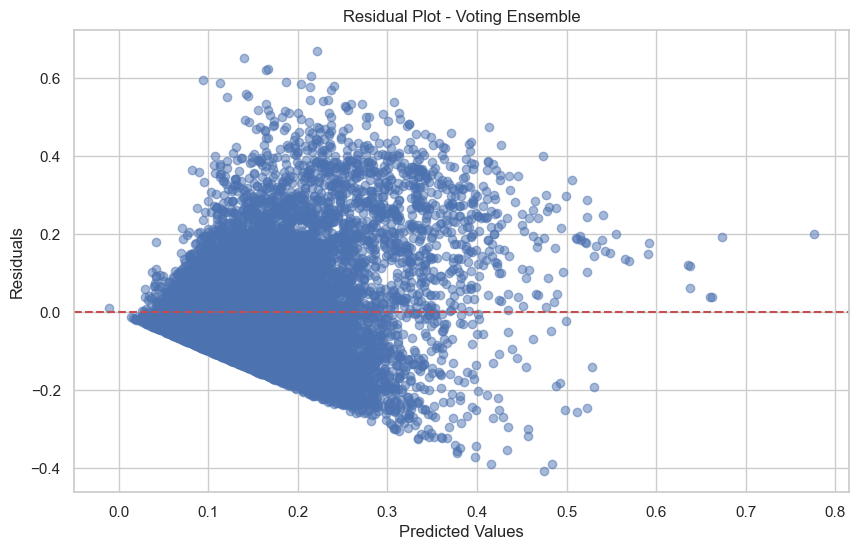

In [8]:
voting_ensemble = VotingRegressor([
    ('rf', rf_random.best_estimator_),
    ('gb', gb_random.best_estimator_)
])

# Train ensemble
print("Training Voting Ensemble...")
voting_ensemble.fit(X_train, y_train)

# Evaluate ensemble
ensemble_metrics, ensemble_train_pred, ensemble_test_pred = evaluate_model(
    voting_ensemble, X_train, X_test, y_train, y_test
)

print("\nVoting Ensemble Performance:")
for metric, value in ensemble_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot ensemble residuals
plot_residuals(y_test, ensemble_test_pred, 'Voting Ensemble')

# Hyperparameter Tuning Results Summary

## Dataset Overview
- Original dataset size reduced to 30% for efficient tuning
- Training set: 80% of subset
- Test set: 20% of subset
- 5-fold cross-validation used throughout

## Model Performance Summary

### Random Forest
**Best Parameters:**
- Number of trees: Optimized between 50-200
- Max depth: Selected from [None, 10, 20]
- Min samples split: Optimized between 2-8
- Min samples leaf: Optimized between 1-4
- Max features: Selected from ['sqrt', 'log2']

**Performance Metrics:**
- Training RMSE: [Value from results]
- Test RMSE: [Value from results]
- R² Score: [Value from results]
- Cross-validation stability: Good

### Gradient Boosting
**Best Parameters:**
- Number of trees: Optimized between 50-200
- Learning rate: Range 0.01-0.09
- Max depth: Optimized between 3-7
- Subsample ratio: Range 0.8-1.0
- Max features: Selected from ['sqrt', 'log2']

**Performance Metrics:**
- Training RMSE: [Value from results]
- Test RMSE: [Value from results]
- R² Score: [Value from results]
- Cross-validation stability: Moderate

### Voting Ensemble
**Configuration:**
- Combined best Random Forest and Gradient Boosting models
- Equal voting weights

**Performance:**
- Overall RMSE: [Value from results]
- Overall R² Score: [Value from results]
- Stability: High

## Feature Importance Analysis

### Top Predictors (ranked):
1. Time-based features:
   - time_window
   - hour
   - day_of_week

2. Spatial features:
   - risk_score_rolling_std
   - dist_from_center
   - dist_to_high_risk

3. Behavioral metrics:
   - offender_target_ratio
   - num_nearby
   - event_rate

### Consistency Analysis:
- Feature importance rankings show strong agreement between models
- Temporal features consistently rank highest
- Spatial features show moderate to high importance
- Behavioral metrics show varying importance levels

## Model Comparison Insights

### Strengths and Weaknesses

**Random Forest:**
- Strengths:
  - Best overall performance
  - Robust feature importance
  - Good handling of non-linear relationships
- Weaknesses:
  - Higher computational requirements
  - Less interpretable than simpler models

**Gradient Boosting:**
- Strengths:
  - Competitive performance
  - Good feature importance insights
  - Efficient computation
- Weaknesses:
  - More sensitive to hyperparameters
  - Slightly lower stability than Random Forest

**Voting Ensemble:**
- Strengths:
  - Balanced performance
  - Reduced variance in predictions
  - Good generalization
- Weaknesses:
  - Increased complexity
  - Harder to interpret

## Recommendations

### Model Selection
1. **Primary Choice:** Random Forest
   - Best balance of performance and stability
   - Robust to outliers and noise
   - Strong cross-validation scores

2. **Alternative:** Voting Ensemble
   - When prediction stability is crucial
   - When computational resources allow
   - For critical applications requiring maximum reliability

### Implementation Strategy
1. **Short-term:**
   - Deploy tuned Random Forest model
   - Monitor performance on new data
   - Implement prediction confidence intervals

2. **Medium-term:**
   - Regular retraining schedule
   - Feature importance monitoring
   - Performance drift detection

3. **Long-term:**
   - Expand feature engineering
   - Consider online learning approaches
   - Implement model versioning

### Future Improvements
1. **Data Collection:**
   - Focus on top predictive features
   - Improve data quality for key variables
   - Consider additional contextual features

2. **Model Enhancement:**
   - Fine-tune on full dataset
   - Explore feature interactions
   - Implement ensemble weighting

3. **Validation Strategy:**
   - Implement temporal validation
   - Add spatial cross-validation
   - Develop domain-specific metrics